In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 14:33:57 2023

@author: Lin
"""

import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path+'/../../')
import myInput
import post_processing as inclination_processing
import PACKAGE_MP_3DLinear as linear3d

## 3D grain size distribution

In [25]:

if __name__ == '__main__':
    # File name
    # case_name = "264_5kMab"
    case_name = "3D_450_20k_newInc"
    init_file_folder = "/orange/michael.tonks/lin.yang/IC/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    npy_file_name_aniso =  f"p_ori_fully5d_fz_aveE_f1.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_anisom = f"p_ori_fully5d_fz_aveE_f1.0_t0.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_anisoi = f"p_ori_fully5d_fz_aveE_f0.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_anisoab =  f"p_ori_fully5d_fzab3_aveE_f1.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_anisoabm = f"p_ori_fully5d_fzab_aveE_f1.0_t0.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_anisoabi = f"p_ori_fully5d_fzab3_aveE_f0.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_iso = f"p_iso_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    input_npy_data = [npy_file_folder+npy_file_name_iso, npy_file_folder+npy_file_name_aniso, npy_file_folder+npy_file_name_anisom, npy_file_folder+npy_file_name_anisoi,npy_file_folder+npy_file_name_anisoab, npy_file_folder+npy_file_name_anisoabm, npy_file_folder+npy_file_name_anisoabi]
    compare_label = [ "Iso", "Fully-Cos", "M-Cos", "I-Cos","Fully-Well", "M-Well", "I-Well"]

    # Get time step with expected grain num
    expected_grain_num = 1000
    special_step_distribution, microstructure_list = inclination_processing.calculate_expected_step(input_npy_data, expected_grain_num)
    print(f"Steps for {compare_label} are {list(map(int, special_step_distribution))}")
    

    # misorientation
    # grain_num = 5000
    # Osym = 24
    # symm2quat_matrix, quartAngle = pre_operation_misorientation(grain_num, init_file_folder + init_file_name, Osym)
    # num_bin = 100
    # axis_num_bin = 200
    # print("> Pre-work done")


100%|██████████| 56/56 [04:10<00:00,  4.48s/it]

> Step calculation done
Steps for ['Iso', 'Fully-Cos', 'M-Cos', 'I-Cos', 'Fully-Well', 'M-Well', 'I-Well'] are [44, 42, 39, 43, 43, 40, 43]


In [26]:
    # Get grain size distribution
    grain_size_list_norm_list = []
    for i in range(len(input_npy_data)):
        size_data_name = f"/size_data/grain_size_data_{case_name}_{compare_label[i]}_step{special_step_distribution[i]}.npz"
        if os.path.exists(current_path + size_data_name):
            grain_size_npz_file = np.load(current_path + size_data_name)
            grain_size_list_norm = grain_size_npz_file["grain_size_list_norm"]
        else:
            current_microstructure = microstructure_list[i]
            grain_id_list = np.unique(current_microstructure)
            grain_area_list = np.zeros(len(grain_id_list))
            for k in range(len(grain_id_list)):
                grain_area_list[k] = np.sum(current_microstructure==grain_id_list[k])

            grain_size_list = (grain_area_list*3/4/np.pi)**(1/3)
            grain_size_ave = np.sum(grain_size_list)/len(grain_size_list)
            grain_size_list_norm = grain_size_list/grain_size_ave
            grain_size_list_norm_log = np.log10(grain_size_list_norm)
            np.savez(current_path + size_data_name,grain_size_list_norm=grain_size_list_norm)
        grain_size_list_norm_list.append(grain_size_list_norm)



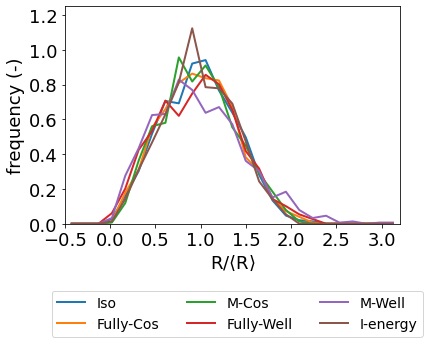

In [38]:

    # plot Normalized Grain Size Distribution figure [-2.5,1.5]
    compare_label = [ "Iso", "Fully-Cos", "M-Cos", "I-Cos","Fully-Well", "M-Well", "I-energy"]
    xLim = [-0.5, 3.2]
    binValue = 0.15
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    case_num = len(input_npy_data)
    freqArray = np.zeros((case_num, binNum))
    for i in range(case_num):
        # if i==2 or i==5 or i==4 or i==1 or i==3: continue
        for k in range(len(grain_size_list_norm_list[i])):
            freqArray[i, int((grain_size_list_norm_list[i][k]-xLim[0])/binValue)] += 1
        freqArray[i] = freqArray[i] / sum(freqArray[i]*binValue)
    plt.figure()
    for i in range(case_num):
        if i==3: continue
        plt.plot(xCor,freqArray[i], linewidth=2, label=compare_label[i])
    plt.xlabel(r"R/$\langle$R$\rangle$", fontsize=18)
    plt.ylabel("frequency (-)", fontsize=18)
    # plt.title(f"grain num: {expected_grain_num}", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim([0,1.25])
    plt.xlim(xLim)
    plt.legend(loc=(-0.04,-0.52),fontsize=14, ncol=3)
    plt.savefig(f'./size_figures/normalized_grain_size_distribution_{case_name}_compare_grain{expected_grain_num}.png',dpi=400,bbox_inches='tight')


## 2D grain size distribution

In [6]:

if __name__ == '__main__':
    # File name
    case_name = "2D_20k_newInclination"
    init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    npy_file_folder_iso = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_anisom = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_anisoi = f"p_aveE_fz_fully5d_20k_J1_f0.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_anisoab =  f"p_aveE_fzab3_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_anisoabm = f"p_aveE_fzab_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_anisoabi = f"p_aveE_fzab3_fully5d_20k_J1_f0.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_iso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_iso = f"p_ori_ave_aveE_20000_multiCore32_delta0.0_m2_J1_refer_1_0_0_seed56689_kt066.npy"
    input_npy_data = [npy_file_folder_iso+npy_file_name_iso, npy_file_folder+npy_file_name_aniso, npy_file_folder+npy_file_name_anisom, npy_file_folder+npy_file_name_anisoi,npy_file_folder+npy_file_name_anisoab, npy_file_folder+npy_file_name_anisoabm, npy_file_folder+npy_file_name_anisoabi]
    compare_label = [ "Iso", "Fully-Cos", "M-Cos", "I-Cos","Fully-Well", "M-Well", "I-Well"]

    # Get time step with expected grain num
    expected_grain_num = 5000
    special_step_distribution, microstructure_list = inclination_processing.calculate_expected_step(input_npy_data, expected_grain_num)
    print(f"Steps for {compare_label} are {list(map(int, special_step_distribution))}")

100%|██████████| 201/201 [00:39<00:00,  5.14it/s]


> Step calculation done
Steps for ['Iso', 'Fully-Cos', 'M-Cos', 'I-Cos', 'Fully-Well', 'M-Well', 'I-Well'] are [4, 5, 4, 5, 4, 4, 4]


In [4]:
    # Get grain size distribution
    grain_size_list_norm_list = []
    for i in range(len(input_npy_data)):
        size_data_name = f"/size_data/grain_size_data_{case_name}_{compare_label[i]}_step{special_step_distribution[i]}.npz"
        if os.path.exists(current_path + size_data_name):
            grain_size_npz_file = np.load(current_path + size_data_name)
            grain_size_list_norm = grain_size_npz_file["grain_size_list_norm"]
        else:
            current_microstructure = microstructure_list[i]
            grain_id_list = np.unique(current_microstructure)
            grain_area_list = np.zeros(len(grain_id_list))
            for k in range(len(grain_id_list)):
                grain_area_list[k] = np.sum(current_microstructure==grain_id_list[k])

            grain_size_list = (grain_area_list*3/4/np.pi)**(1/3)
            grain_size_ave = np.sum(grain_size_list)/len(grain_size_list)
            grain_size_list_norm = grain_size_list/grain_size_ave
            grain_size_list_norm_log = np.log10(grain_size_list_norm)
            np.savez(current_path + size_data_name,grain_size_list_norm=grain_size_list_norm)
        grain_size_list_norm_list.append(grain_size_list_norm)



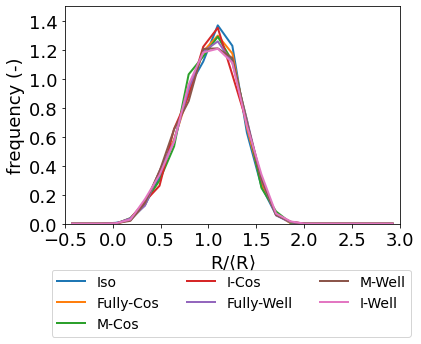

In [5]:

    # plot Normalized Grain Size Distribution figure [-2.5,1.5]
    compare_label = [ "Iso", "Fully-Cos", "M-Cos", "I-Cos","Fully-Well", "M-Well", "I-Well"]
    xLim = [-0.5, 3.0]
    binValue = 0.15
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    case_num = len(input_npy_data)
    freqArray = np.zeros((case_num, binNum))
    for i in range(case_num):
        # if i==2 or i==5 or i==4 or i==1 or i==3: continue
        for k in range(len(grain_size_list_norm_list[i])):
            freqArray[i, int((grain_size_list_norm_list[i][k]-xLim[0])/binValue)] += 1
        freqArray[i] = freqArray[i] / sum(freqArray[i]*binValue)
    plt.figure()
    for i in range(case_num):
        # if i==3: continue
        plt.plot(xCor,freqArray[i], linewidth=2, label=compare_label[i])
    plt.xlabel(r"R/$\langle$R$\rangle$", fontsize=18)
    plt.ylabel("frequency (-)", fontsize=18)
    # plt.title(f"grain num: {expected_grain_num}", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim([0,1.5])
    plt.xlim(xLim)
    plt.legend(loc=(-0.04,-0.52),fontsize=14, ncol=3)
    plt.savefig(f'./size_figures/normalized_grain_size_distribution_{case_name}_compare_grain{expected_grain_num}2.png',dpi=400,bbox_inches='tight')


## 2D grain size distribution for fzabBi


In [3]:

if __name__ == '__main__':
    # File name
    case_name = "20k_Bi"
    init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    npy_file_folder_iso = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/results/"
    npy_file_name_aniso = f"p_aveE_fzabBi_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_anisomi = f"p_aveE_fzabBi_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso_fully = f"p_aveE_fzBi_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_anisoab = f"p_ori_fully5d_fzab_aveE_f1.0_t1.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    # npy_file_name_anisoabm = f"p_ori_fully5d_fzab_aveE_f1.0_t0.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_iso = f"p_aveE_fzabBi_fully5d_20k_J1_f0.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"
    input_npy_data = [npy_file_folder+npy_file_name_aniso, npy_file_folder+npy_file_name_anisomi, npy_file_folder+npy_file_name_aniso_fully, npy_file_folder+npy_file_name_iso]
    compare_label = ["Aniso-M", "Aniso-M&I", "Fully-M&I", "Iso"]

    # Get time step with expected grain num
    expected_grain_num = 1000
    special_step_distribution, microstructure_list = inclination_processing.calculate_expected_step(input_npy_data, expected_grain_num)
    print(f"Steps for {compare_label} are {list(map(int, special_step_distribution))}")

100%|██████████| 201/201 [00:31<00:00,  6.31it/s]

> Step calculation done
Steps for ['Aniso-M', 'Aniso-M&I', 'Fully-M&I', 'Iso'] are [13, 16, 16, 12]


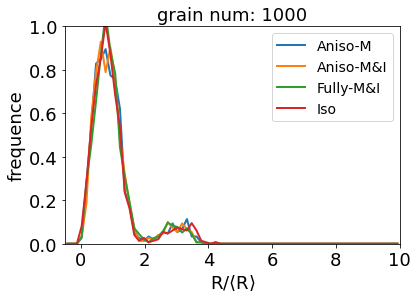

In [4]:
    # Get grain size distribution
    grain_size_list_norm_list = []
    for i in range(len(input_npy_data)):
        size_data_name = f"/size_data/2D_grain_size_data_{case_name}_{compare_label[i]}_step{special_step_distribution[i]}.npz"
        if os.path.exists(current_path + size_data_name):
            grain_size_npz_file = np.load(current_path + size_data_name)
            grain_size_list_norm = grain_size_npz_file["grain_size_list_norm"]
        else:
            current_microstructure = microstructure_list[i]
            grain_id_list = np.unique(current_microstructure)
            grain_area_list = np.zeros(len(grain_id_list))
            for k in range(len(grain_id_list)):
                grain_area_list[k] = np.sum(current_microstructure==grain_id_list[k])

            grain_size_list = (grain_area_list/np.pi)**0.5
            grain_size_ave = np.sum(grain_size_list)/len(grain_size_list)
            grain_size_list_norm = grain_size_list/grain_size_ave
            grain_size_list_norm_log = np.log10(grain_size_list_norm)
            # np.savez(current_path + size_data_name,grain_size_list_norm=grain_size_list_norm)
        grain_size_list_norm_list.append(grain_size_list_norm)


    # plot Normalized Grain Size Distribution figure [-2.5,1.5]
    xLim = [-0.5, 10]
    binValue = 0.15
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    case_num = len(input_npy_data)
    freqArray = np.zeros((case_num, binNum))
    for i in range(case_num):
        for k in range(len(grain_size_list_norm_list[i])):
            freqArray[i, int((grain_size_list_norm_list[i][k]-xLim[0])/binValue)] += 1
        freqArray[i] = freqArray[i] / sum(freqArray[i]*binValue)
    plt.figure()
    for i in range(case_num):
        plt.plot(xCor,freqArray[i], linewidth=2, label=compare_label[i])
    plt.xlabel(r"R/$\langle$R$\rangle$", fontsize=18)
    plt.ylabel("frequence", fontsize=18)
    plt.title(f"grain num: {expected_grain_num}", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim([0,1.0])
    plt.xlim(xLim)
    plt.legend(fontsize=14)
    plt.savefig(f'./size_figures/normalized_grain_size_distribution_{case_name}_compare_grain{expected_grain_num}.png',dpi=400,bbox_inches='tight')


In [5]:
    import importlib
    importlib.reload(inclination_processing)
    
    expected_grain_num_list = [10000,5000,4500,4000,3500,3000,2500,2000,1500,1000,500]
    
    
    # Get time step with expected grain num
    ss = 0
    for expected_grain_num in expected_grain_num_list:
        # expected_grain_num = 5000
        special_step_distribution, microstructure_list = inclination_processing.calculate_expected_step(input_npy_data, expected_grain_num)
        print(f"Steps for {compare_label} are {list(map(int, special_step_distribution))}")

        # Get grain size distribution
        grain_size_list_norm_list = []
        for i in range(len(input_npy_data)):
            size_data_name = f"/size_data/2D_grain_size_data_{case_name}_{compare_label[i]}_step{special_step_distribution[i]}.npz"
            if os.path.exists(current_path + size_data_name):
                grain_size_npz_file = np.load(current_path + size_data_name)
                grain_size_list_norm = grain_size_npz_file["grain_size_list_norm"]
            else:
                current_microstructure = microstructure_list[i]
                grain_id_list = np.unique(current_microstructure)
                grain_area_list = np.zeros(len(grain_id_list))
                for k in range(len(grain_id_list)):
                    grain_area_list[k] = np.sum(current_microstructure==grain_id_list[k])

                grain_size_list = (grain_area_list/np.pi)**0.5
                grain_size_ave = np.sum(grain_size_list)/len(grain_size_list)
                grain_size_list_norm = grain_size_list/grain_size_ave
                grain_size_list_norm_log = np.log10(grain_size_list_norm)
                # np.savez(current_path + size_data_name,grain_size_list_norm=grain_size_list_norm)
            grain_size_list_norm_list.append(grain_size_list_norm)


        # plot Normalized Grain Size Distribution figure [-2.5,1.5]
        xLim = [-0.5, 10]
        binValue = 0.15
        binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
        xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
        case_num = len(input_npy_data)
        freqArray = np.zeros((case_num, binNum))
        for i in range(case_num):
            for k in range(len(grain_size_list_norm_list[i])):
                freqArray[i, int((grain_size_list_norm_list[i][k]-xLim[0])/binValue)] += 1
            freqArray[i] = freqArray[i] / sum(freqArray[i]*binValue)
        plt.figure()
        for i in range(case_num):
            plt.plot(xCor,freqArray[i], linewidth=2, label=f"{compare_label[i]}({int(special_step_distribution[i])})")
        plt.xlabel(r"R/$\langle$R$\rangle$", fontsize=18)
        plt.ylabel("frequence", fontsize=18)
        plt.title(f"grain num: {expected_grain_num}", fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.ylim([0,1.1])
        plt.xlim([-0.5,7])
        plt.legend(fontsize=12)
        if ss < 10: grain_step = f"00{ss}"
        elif ss < 100: grain_step = f"0{ss}"
        else: grain_step = f"{ss}"
        ss+=1
        plt.savefig(f'./size_figures/normalized_grain_size_distribution_{case_name}_compare_grain.{grain_step}.png',dpi=400,bbox_inches='tight')


100%|██████████| 201/201 [00:31<00:00,  6.39it/s]


> Step calculation done
Steps for ['Aniso-M', 'Aniso-M&I', 'Fully-M&I', 'Iso'] are [1, 1, 1, 1]


100%|██████████| 201/201 [00:31<00:00,  6.39it/s]


> Step calculation done
Steps for ['Aniso-M', 'Aniso-M&I', 'Fully-M&I', 'Iso'] are [3, 3, 3, 3]


100%|██████████| 201/201 [00:31<00:00,  6.39it/s]


> Step calculation done
Steps for ['Aniso-M', 'Aniso-M&I', 'Fully-M&I', 'Iso'] are [3, 4, 4, 3]


100%|██████████| 201/201 [00:31<00:00,  6.40it/s]


> Step calculation done
Steps for ['Aniso-M', 'Aniso-M&I', 'Fully-M&I', 'Iso'] are [3, 4, 4, 3]


100%|██████████| 201/201 [00:31<00:00,  6.38it/s]


> Step calculation done
Steps for ['Aniso-M', 'Aniso-M&I', 'Fully-M&I', 'Iso'] are [4, 5, 5, 4]


 17%|█▋        | 35/201 [00:06<00:26,  6.23it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [7]:
import os

os.system(f'ffmpeg -framerate 5 -i ./size_figures/normalized_grain_size_distribution_{case_name}_compare_grain.%03d.png' 
          f' -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p '
          f'size_figures/normalized_grain_size_distribution_{case_name}_compare_grain.mp4')

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  l

0